<a href="https://colab.research.google.com/github/XuRui314/MCM/blob/main/%E2%80%9CM2019C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# preparation
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/dataset/MathModel/M2019C")
!ls

ACS_10_5YR_DP02_metadata.csv  ACS_14_5YR_DP02_with_ann.csv  Heroin_2014_0.png
ACS_10_5YR_DP02_with_ann.csv  ACS_15_5YR_DP02_metadata.csv  Heroin_2014_1.png
ACS_11_5YR_DP02_metadata.csv  ACS_15_5YR_DP02_with_ann.csv  Heroin_2014_2.png
ACS_11_5YR_DP02_with_ann.csv  ACS_16_5YR_DP02_metadata.csv  kmeans.xls
ACS_12_5YR_DP02_metadata.csv  ACS_16_5YR_DP02_with_ann.csv  MCM_NFLIS_Data.xls
ACS_12_5YR_DP02_with_ann.csv  counties.txt		    MCM_NFLIS_Data.xlsx
ACS_13_5YR_DP02_metadata.csv  data_GEO_test.xls		    similarity.xls
ACS_13_5YR_DP02_with_ann.csv  data_GEO.xls
ACS_14_5YR_DP02_metadata.csv  distance.xls


In [ ]:
pip install xlutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 6.0 MB/s eta 0:00:00


题目翻译在这里：[link](https://github.com/zouzhenhong98/2019MCM/blob/master/%E7%BE%8E%E8%B5%9BC%E9%A2%98%E7%BF%BB%E8%AF%91.pdf)

复现论文#team 1906204

**问题**：

**第1部分**。使用提供的NFLIS数据，建立一个数学模型来描述报告的合成阿片类药物和海洛因事件（病例）在五个州之间和他们的县之间随着时间的推移的传播和特征。使用您的模型，确定在每个州中任何可能开始使用特定阿片类药物的位置。
如果您的团队确定的模式和特征继续存在，那么美国政府应该如何关注这些问题?在什么药物识别阈值水平下会发生这些情况（开始使用药物)?你的模型预测它们将来何时何地会发生?

**第2部分**。使用美国人口普查提供的社会经济数据，解决以下问题:
有许多相互竞争的假设被提供作为解释阿片类药物的使用如何达到了目前的水平，谁正在使用/滥用它，什么有助于阿片类药物使用的增长和成瘾，以及为什么阿片类药物使用仍然存在。这样的滥用趋势是否与任何美国人口普查社会经济数据相关联?如果是这样，请在第一部分的基础上修改您的模型，添加上所有必要的因素。

**第3部分**。最后，结合使用第1部分和第2部分的结果，确定可能的策略来打击阿片类药物危机。使用您的模型来测试该策略的有效性;识别任何成功(或失败）依赖的重要参数界限。


### Analysis of the problem

**Data Preprocessing**

给的数据是69种不同的阿片类药物在462个不同县的分布，通过数据可以看到有些县的某种药物报告很少，所以为了药物传播分布预测分析，使观察到的传播特征和趋势更加明显，作者使用了K-means聚类对数据进行预处理，划分为区域进行分析。

**Use K-means to Divide Areas**

要适当实施区域化，分区既不要太大也不要太小。通过多次尝试，作者选择将参数k设置为100取得最佳情况。从技术上讲，只使用了基本的K-means算法，所有100个集群都有相同的半径，每个集群的县的数量大致从2到8个。在聚类前，我们将“FIPS_Cungon”转换为相应的经度和纬度，然后应用K-means算法。最后，我们整合了同一区域内每种药物的所有药物鉴定报告。

 **Basic Assumption**

阿片类药物成瘾的分布趋势随时间而变化。在做预测时，我们要考虑到时间。最新的趋势将会有一个较高的影响因素

阿片类药物滥用的传播取决于位置。我们假设药物主要从一个地方传播到邻近的地方，而不会跨越很大的距离。

当处理数据缺失时，我们将其视为平均值。



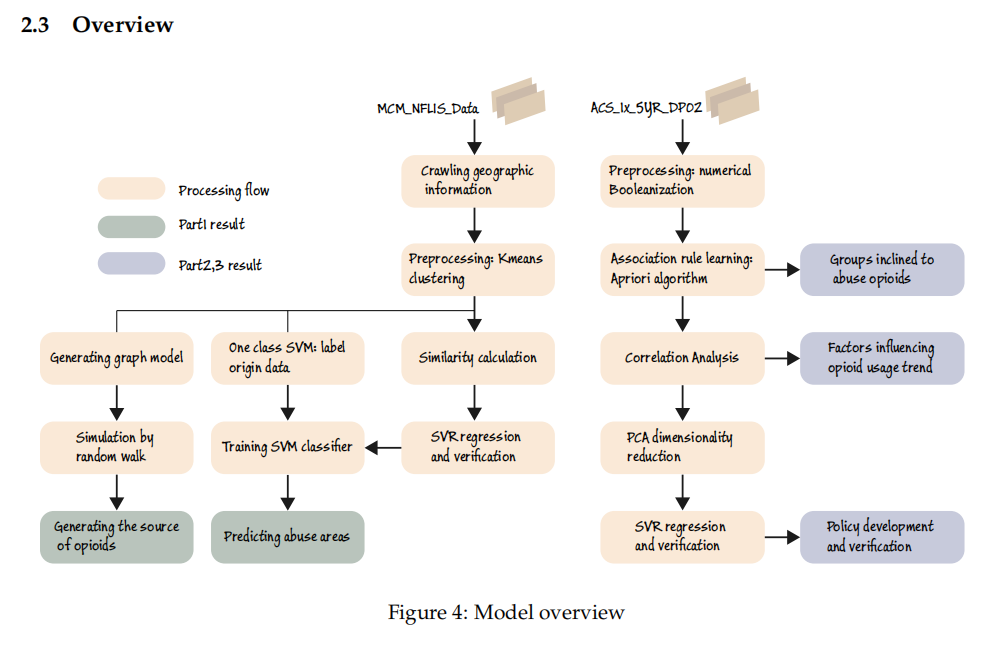

这里首先对原始数据处理一下，增加两列表示经纬度。处理的方法这里是先通过 `countries.txt` 这个文本构造字典，说实话这个真的蛮好用的，是通过官网下载FIPS json文件自己处理得到的。

In [ ]:
import xlrd
import xlwt
from xlutils.copy import copy
import os

FIPS2GEO = {}
# 这里是把乡镇的id和经纬度做成了一个字典
with open("counties.txt",encoding = "utf-8") as county:
    lines = county.readlines()
    for line in lines[1:]:
        line = line.split()
        FIPS2GEO[line[1]]=(line[9],line[10])

FIPS2GEO['51515']=(45.13,-72.96)

data = xlrd.open_workbook("MCM_NFLIS_Data.xls",formatting_info=True)
old_sheet = data.sheets()[1]
rows = old_sheet.nrows
cols = old_sheet.ncols
new_data = copy(data)
table = new_data.get_sheet(1)
# 第一个参数是行，第二个参数是列的位置
table.write(0, 10, "LAT")
table.write(0, 11, "LONG")
for i in range(1,rows):
    FIPS_Combined = str(old_sheet.row_values(i)[5])
    table.write(i, 10, FIPS2GEO[FIPS_Combined][0])
    table.write(i, 11, FIPS2GEO[FIPS_Combined][1])
new_data.save("data_GEO_test.xls")

In [ ]:
import xlrd
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import xlwt
import operator
import copy
from functools import reduce

# 初始化表，返回字典
def init(table):
    nrows = table.nrows
    ncols = table.ncols
    # use FIPS_combined as key to record info
    county = {}
    # print(table.row_values(0)[5]) FIPS_Combined
    # print(table.row_values(0)[10]) LAT
    # print(table.row_values(0)[11]) LONG
    for i in range(1, nrows):
        FIPS_Combined = table.row_values(i)[5]
        if FIPS_Combined not in county.keys():
            lat = float(table.row_values(i)[10])
            lon = float(table.row_values(i)[11])
            county[FIPS_Combined] = (lon, lat)
    return county

# 把经纬度转换成距离
def haversine(pos1, pos2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal into arc system
    lon1, lat1 = pos1
    lon2, lat2 = pos2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # radius of earth, unit as kilometer
    return c * r * 1000


def renew_cluster(centers, pos, cities):
    label = dict().fromkeys([i for i in range(len(centers))], [])
    for city in cities:
        dist = []
        for center in centers:
            #print(center)
            dist.append(haversine(pos[city], center))
        index = dist.index(min(dist))
        cluster = copy.deepcopy(label[index])
        cluster.append(city)

        label[index] = cluster
        new_centers = []

    for i in range(len(centers)):
        positions = list(map(lambda x: pos[x], label[i]))
        #print(positions)
        new_centers.append(np.mean(positions, axis=0))
        #print(new_centers)
        #print(label)
    return new_centers, label

# convert positions into k clusters
def k_means(k, pos):
    cities = list(pos.keys())
    if k > len(cities):
        print("K too large")
        return False
    else:
        # initial centers
        old_centers = [list(pos[cities[i]]) for i in range(k)]
        # itartion until convergence
        while True:
            new_centers, cluster = renew_cluster(old_centers, pos, cities)
            # print(new_centers)

            if (np.array(new_centers) == np.array(old_centers)).all():
                break
            else:
                old_centers = new_centers
    zone = {}
    for key in cluster:
        for city in cluster[key]:
            zone[city] = key
    return new_centers, cluster, zone

def output(centers, cluster, zone, data):
    # new_file = xlwt.Workbook(encoding = 'utf-8')
    # new_table = file.add_sheet('data')
    table = []
    writen = []
    DrugReportZone=[[{} for i in range(100)] for i in range(0,8)]
    TotalDrugReportZone=[[0 for i in range(100)]for i in range(0,8)]
    for i in range(1,data.nrows):
        YYYY = int(data.row_values(i)[0])
        FIPS_Combined = data.row_values(i)[5]
        substanceName = data.row_values(i)[6]
        DrugReport = data.row_values(i)[7]
        TotalDrugReport = data.row_values(i)[8]
        label = zone[FIPS_Combined]
        DrugReportZone[YYYY-2010][label][substanceName] = DrugReportZone[YYYY-2010][label].get(substanceName,0)+DrugReport
        if (YYYY,FIPS_Combined) not in writen:
            TotalDrugReportZone[YYYY-2010][label] += TotalDrugReport
            writen.append((YYYY,FIPS_Combined))
        entry = [YYYY, label, substanceName, DrugReport, TotalDrugReport]
        table.append(entry)
    for entry in table:
        entry[3] = DrugReportZone[entry[0]-2010][entry[1]][entry[2]]
        entry[4] = TotalDrugReportZone[entry[0]-2010][entry[1]]
    #print(table)
    return table
# def f(x, y):
# if (np.array(x[:3]) == np.array(y[:3])).all():
# return x[:3] + [x[3]+y[3]] + [x[4]+y[4]]
# reduce(lambda x, y: f , table)




下面利用ploty对聚类得到的结果进行可视化：

参考资料：https://plotly.com/python/county-choropleth/

In [ ]:

if __name__ == '__main__':
    data = xlrd.open_workbook("data_GEO_test.xls").sheets()[1]
    county = init(data) # 得到的county是FIPS code和经纬度的字典
    centers, cluster, zone = k_means(100, county)

    # print(zone)
    table = output(centers, cluster, zone, data)
    #write data into excel
    excel = xlwt.Workbook()
    sheet1 = excel.add_sheet("Date based on Zone")
    sheet2 = excel.add_sheet("ZoneCounty Correspondence Table")
    sheet3 = excel.add_sheet("County Position")
    sheet1.write(0, 0, "YYYY")
    sheet1.write(0, 1, "Zone")
    sheet1.write(0, 2, "substanceName")
    sheet1.write(0, 3, "DrugReportZone")
    sheet1.write(0, 4, "TotalDrugReportZone")
    for row, entry in enumerate(table):
        for col in range(len(entry)):
            sheet1.write(row+1, col, entry[col])
    sheet2.write(0, 0, "Zone")
    sheet2.write(0, 1, "Latitude")
    sheet2.write(0, 2, "Longitude")

    for row, key in enumerate(list(cluster.keys())):
        sheet2.write(row+1, 0, row)
        sheet2.write(row+1, 1, centers[row][1])
        sheet2.write(row+1, 2, centers[row][0])
        for col in range(len(cluster[key])):
            sheet2.write(row+1, col+3, cluster[key][col])
    sheet3.write(0, 0, "County")
    sheet3.write(0, 1, "FIS_Combined")
    sheet3.write(0, 2, "Latitude")
    sheet3.write(0, 3, "Longitude")
    written = []
    row_num = 0
    for row in range(1, data.nrows):
        entry = data.row_values(row)
        #print(entry)
        if entry[2] not in written:
            row_num += 1
            written.append(entry[2])
            info = [entry[2], entry[3]+'+'+entry[4], entry[10], entry[11]]
            for col in range(4):
                sheet3.write(row_num, col, info[col])
    excel.save("kmeans.xls")

下面来演示一下plotly画所有fips区域，参考资料：https://medium.com/analytics-vidhya/plotly-for-geomaps-bb75d1de189f

In [ ]:
# preparation
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
import plotly.express as px

data = xlrd.open_workbook("data_GEO_test.xls").sheets()[1]
county = init(data) # 得到的county是FIPS code和经纬度的字典
centers, cluster, zone = k_means(100, county)

data_zone = pd.DataFrame({'fips':list(zone), 'clusters':list(zone.values())} )

import plotly.graph_objects as go
fig = go.Figure(go.Choroplethmapbox(geojson=counties, locations=data_zone.fips, z=data_zone.clusters,
                                    colorscale="Viridis", zmin=0, zmax=100,
                                    marker_opacity=0.5, marker_line_width=0))
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=3, mapbox_center = {"lat": 37.0902, "lon": -95.7129})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
configure_plotly_browser_state()

init_notebook_mode(connected=False)
fig.show()

### Models

 **Basic Model Description**

为了找出所报告的合成阿片类药物和海洛因事件在五个州及其县之间的传播和特点，确定其来源和预测未来可能的药物使用情况，作者决定使用推荐系统。

**Recommendation System**

模型反映了“推荐系统”的主要理念，即寻找相似的区域。这些类似的区域将在很大程度上具有所报告的合成阿片类药物和海洛因事件的相似传播和特征。这些类似的区域帮助我们增强了传播的特征，并使预测更加准确。





**Mathematical Formulation**

由于有100个区域和69个不同的阿片类药物，作者创建了一个100×69矩阵。每一行代表一个区域号，每一列代表一个阿片类药物编号。那么这个矩阵中的项（i，j）将表示i区中j个药物的一些信息。这些信息由于不同的目的而会有所不同

对于相似性的衡量，这篇论文是主要考虑了三个因素，(1) 随时间的变化趋势 (2) 地理因素 (3) 药物鉴定大小。



**"Walk Around" in Graph to fifind Origin**

作者将这节分为三大步。

**第一步**是构建一个阿片类药物的传播图模型。假设我们正在寻找海洛因的来源。我们的模型的第一步是构建一个阿片类药物的传播映射模型。我们选择了任何一年的海洛因数据。图中的每个节点代表一个聚类点，每个节点的权重代表在该地方吸食这种药物的人数。当节点A（WA）的数量高于其他节点B（WB）时，将生成从A到B的有向边（A->B）。边缘的权重是A和B的相似性（sim（A，B）=pA−>B）。为海洛因生成的图表如下所示。

**第二步**是根据上述图模型找到可能成为药物来源的节点。我们称之为候选集。CandidateSet = {node1, node2, node3, ...}.在图论中，图的顶点的度（或价）是与顶点相关的边的数量，循环计算两次。在这里，我们将定义更改为从顶点分散的边的数量。对于每个节点，我们计算其度（Deg (v)），我们选择最大的5个节点，并将它们存储在候选集中。

**第三步**是利用随机游动的模拟方法来模拟药物的传播行为。分别模拟候选集中的节点，对每个节点模拟100次，记录其他节点的访问次数（ni），并按以下公式计算每个节点的得分。得分最高的是我们想要找到的来源。

但是在代码里他并没有写random walk这步，也没有给出转移概率的计算方法。


In [ ]:
pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.1 MB/s eta 0:00:00


In [ ]:
import xlrd
import pandas as pd
import numpy as np
from math import *
import xlwt
import operator
import copy
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
from itertools import combinations
from igraph import *
import seaborn as sns
import pylab
import random
import seaborn as sns

# 这是对于k-means表的初始化
# 返回的是drug2num，num2drug两个转换用的列表/字典
# dataslice是对k-means表的切片，其中的每行对应一个元素，center是每个区域对应中心经纬度的字典
def init(data):
    sheet1 = dasheet1 = data.sheets()[0] # Date based on Zone
    sheet2 = data.sheets()[1] # ZoneCounty Correspondence Table
    sheet3 = data.sheets()[2] # County Position
    # map substanceName to Drug number
    drug2num = {}
    num2drug = []

    rank = 0
    dataslice = [[], [], [], [], [], [], [], []]
    for row in range(1, sheet1.nrows):
        entry = sheet1.row_values(row)
        YYYY = entry[0]
        substanceName = entry[2]
        if substanceName not in drug2num.keys():
            drug2num[substanceName] = rank
            num2drug.append(substanceName)
            rank += 1

        # seperate this data into 8 parts by year
        if YYYY == 2010:
            dataslice[0].append(entry)
        if YYYY == 2011:
            dataslice[1].append(entry)
        if YYYY == 2012:
            dataslice[2].append(entry)
        if YYYY == 2013:
            dataslice[3].append(entry)
        if YYYY == 2014:
            dataslice[4].append(entry)
        if YYYY == 2015:
            dataslice[5].append(entry)
        if YYYY == 2016:
            dataslice[6].append(entry)
        if YYYY == 2017:
            dataslice[7].append(entry)

    # dict to store each zone's position
    center = {}
    for row in range(1, sheet2.nrows):
        entry = sheet2.row_values(row)
        zone = int(entry[0])
        if zone not in center.keys():
            lat = entry[1]
            lon = entry[2]
        center[zone] = (lon, lat)

    return drug2num, num2drug, dataslice, center

# 其实就是100 x 100的邻接矩阵
def make_distance_xls(center):
    excel = xlwt.Workbook()
    sheet1 = excel.add_sheet("distance")
    for i in range(0,100):
        for j in range(0,100):
            sheet1.write(i,j,haversine(center[i],center[j]))
    excel.save("distance.xls")

# sim文件是100 x 100的相似度矩阵
def make_simi_xls(data,center,alpha):
    # 传进来的data就是(100, 69, 7)的矩阵
    excel = xlwt.Workbook()
    sheet1 = excel.add_sheet("sim")
    for i in range(0,100):
        dict={}
        ad = cal_simi(i,data,center,alpha)
        for it in ad:
            dict[it[0]]=it[1] # 其实ad每一项是i区域对it[0]区域的相似性值
        for j in range(0,100):
            if i==j:
                sheet1.write(i, j, 1)
            else:
                sheet1.write(i,j,dict.get(j,0))
    excel.save("similarity.xls")


# 计算相似度，只算距离在alpha内的点
# 计算的是zone区域和其余符合要求区域的相似度
# 
def cal_simi(zone, data, center, alpha):
    # 传进来的data就是(100, 69, 7)的矩阵
    adjacentZones = []
    for i in range(100):
        if i != zone and haversine(center[i], center[zone]) < alpha:
            Sum = np.sum(np.sum(np.array(data[i]))) + np.sum(np.sum(np.array(data[zone])))
            corr = 0
            for j in range(69):
                # 算区域i和区域j每个毒品在7年趋势的相关系数，然后累加得到区域i和区域j的相似度
                tendency_i = data[i][j]
                tendency_zone = data[zone][j]
                sum_i = np.sum(np.array(tendency_i))
                sum_zone = np.sum(np.array(tendency_zone))
                if sum_zone == 0 or sum_i == 0:
                    continue
                por = sum_i + sum_zone
                coef = np.corrcoef(tendency_i, tendency_zone)[0, 1]
                if isnan(coef) or coef == 0:
                    pass
                else:
                    corr += coef * 1.0 * por / Sum
            adjacentZones.append([i, corr])
    return adjacentZones

def sparseMatrix(data, drug2num, num2drug):
    """
    Matrix has 100 zones, each forms a row
    each row represents the num of drug report in that zone for each drugs
    initially, we set it all to zeros
    """
    # len(num2drug) = 69
    sparseMatrix = np.zeros([100, 69])
    for row in range(len(data)):
        zone = int(data[row][1])
        drugName = data[row][2]
        drugNum = drug2num[drugName]
        drugReport = data[row][3]
        sparseMatrix[zone][drugNum] += drugReport
    return sparseMatrix


def haversine(pos1, pos2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal into arc system
    lon1, lat1 = pos1
    lon2, lat2 = pos2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # radius of earth, unit as kilometer
    return c * r * 1000
def get_new_edges(edges, origin):
    new_edges = []
    color_mat = []
    for i in range(len(edges)):
        if(edges[i][0] == origin):
            new_edges.append(edges[i])
            color_mat.append([edges[i],'salmon'])
    s_edges = new_edges
    for i in range(len(new_edges)):
        tem = new_edges[i][1]
        for k in range(len(edges)):
            if (edges[k][0] == tem):
                s_edges.append(edges[k])
                color_mat.append([edges[k],'navajowhite'])
    t_edges = s_edges
    # print(s_edges)
    for i in range(len(s_edges)):
        tem1 = s_edges[i][1]
        for k in range(len(edges)):
            if(edges[k][0] == tem1):
                t_edges.append(edges[k])
                color_mat.append([edges[k], 'mediumslateblue'])
    return t_edges, color_mat

def similarity(zone, data, center, alpha):
    adjacentZones = cal_simi(zone,data,center,alpha)
    if len(adjacentZones) > 10:
        adjacentZones.sort(key=lambda x: x[1])
        return list(map(lambda x: x[0], adjacentZones[-10:]))
    else:
        return list(map(lambda x: x[0], adjacentZones))


def adjMatrix(medical_name, time, distance_threshold):
    G=nx.DiGraph()
    H=nx.DiGraph()
    M=nx.DiGraph()
    excel_path = 'kmeans.xls'
    klocation = pd.read_excel(excel_path, sheet_name='ZoneCounty Correspondence Table')
    print(klocation)
    kdata = pd.read_excel(excel_path, sheet_name='Date based on Zone')
    
    distance = pd.read_excel('distance.xls', sheet_name='distance',header=None).values
    simi = pd.read_excel('similarity.xls',sheet_name = 'sim',header=None).values

    edges = []
    medical_data = kdata[(kdata['substanceName'] == medical_name) & (kdata['YYYY'] == time)]
    combins = [list(c) for c in combinations(set(medical_data['Zone'].values.tolist()), 2)] # 这个其实就是存组合数[[0, 0], [0, 1], ...]，用于枚举用的
    #print(medical_data)
    #print(combins)
    weights = []

    for i in range(len(combins)):
        x = combins[i][0]
        y = combins[i][1]
        if distance[x, y] < distance_threshold:
            #print(medical_data[medical_data['Zone'] == x])
            #print(medical_data[medical_data['Zone'] == y])
            if (sum(medical_data[medical_data['Zone'] == x]['DrugReportZone'].values)
                    >=sum(medical_data[medical_data['Zone'] == y]['DrugReportZone'].values)):
                edges.append(combins[i])
                G.add_edges_from([combins[i]], weight = round(simi[combins[i][0],combins[i][1]],1))
                weights.append(round(simi[combins[i][0],combins[i][1]],1))
            else:
                combins[i].reverse()
                edges.append(combins[i])
                #print(combins[i].reverse())
                G.add_edges_from([combins[i]], weight = round(simi[combins[i][0], combins[i][1]],1))
                weights.append(round(simi[combins[i][0], combins[i][1]],1))
    # print(edges)
    # 度数前三随机选一个就当成origin，没有random walk的过程
    degree = [[x, 0] for x in range(100)]
    for i in range(len(edges)):
        degree[edges[i][0]][1] += 1
    degree.sort(key=lambda x: x[1], reverse=True)
    ra = random.randint(0, 3)
    origin = degree[ra][0]

    print(degree)
    # Draw the picture
    # G.add_edges_from(edges)
    ind = []
    posi = []
    for i in range(100):
        ind.append(i)
        posi.append((klocation['Longitude'].iloc[i], klocation['Latitude'].iloc[i]))
    position = dict(zip(ind, posi))
    vals = []
    for i in range(100):
        vals.append(int(sum(medical_data[medical_data['Zone'] == i]['DrugReportZone'].values)))
    values_dic = dict(zip(ind, vals))
    values = [values_dic.get(node, 1.0) for node in G.nodes()]
    for i in range(len(values)):
        values[i] = values[i] - 10
        if (values[i] > 210):
            values[i] = 210
    edge_labels = dict([((u, v,), d['weight'])for u, v, d in G.edges(data=True)])

    plt.figure()
    nx.draw_networkx_edge_labels(G,pos = position ,edge_labels=edge_labels)
    # nx.draw_networkx_edges(G, pos = position, width = 2, alpha = 0.5, arrows = True, arrowstyle='->',edge_color=weights,with_labels=True)
    nx.draw(G, pos = position, node_color = "skyblue", node_size = 2000,with_labels=True)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(40, 20)
    plt.savefig(str(medical_name) + '_' + str(time) + "_" + "0.png") # save as png

    plt.figure()
    
    nx.draw_networkx(G, pos = position, width = 3 ,node_size = 2000, node_color= values,cmap = sns.color_palette("rocket", as_cmap=True),edge_cmap = sns.color_palette("rocket", as_cmap=True),  arrows = True, edge_color=weights,with_labels=True)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(40, 20)
    plt.savefig(str(medical_name) + '_' + str(time) + "_" + "1.png") # save as png

    plt.figure()
    new_edges, edges_colors = get_new_edges(edges, origin)
    for i in range(len(new_edges)):
        H.add_edges_from([new_edges[i]], weight = round(simi[new_edges[i][0],new_edges[i][1]]))
    nx.draw_networkx_nodes(H,pos = position,cmap=plt.get_cmap('jet'), node_size=2000, node_shape="o",alpha=0.8,
    node_color = 'skyblue')
    nx.draw_networkx_edges(H, pos = position, width = 1, alpha = 0.5, arrowstyle='->')
    plt.scatter(position[origin][0], position[origin][1], color='royalblue', marker='o', edgecolors='g', s=3500)
    plt.text(position[origin][0], position[origin][1], str(origin), fontsize=20, style='oblique', ha='center',va='top',wrap=True)
    plt.xlabel('lng')
    plt.ylabel('lat')
    #nx.draw(H, pos = position, node_color ='skyblue', node_size = 1000, edge_cmp = plt.cm.Reds)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(40, 20)
    pylab.savefig(str(medical_name) + '_' + str(time) + "_" + "2.png") # save as png

<ipython-input-11-78562690664e>:6: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



    Zone   Latitude  Longitude  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0      0  37.498022 -75.983544       51001     51115.0     51131.0   
1      1  38.805464 -83.074629       39001     39079.0     21089.0   
2      2  39.970700 -77.233645       42001     42041.0     42055.0   
3      3  38.848794 -77.092186       51510     51013.0         NaN   
4      4  40.149489 -79.913009       42003     42051.0     42059.0   
..   ...        ...        ...         ...         ...         ...   
95    95  37.276155 -83.886770       21051     21125.0     21109.0   
96    96  36.806425 -84.979435       21053     21057.0     21147.0   
97    97  41.457788 -77.336303       42035     42081.0     42117.0   
98    98  40.307993 -82.056502       39031     39075.0     39083.0   
99    99  37.382898 -80.547161       51045     51071.0     51121.0   

    Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0          NaN         NaN         NaN         NaN          NaN          NaN   

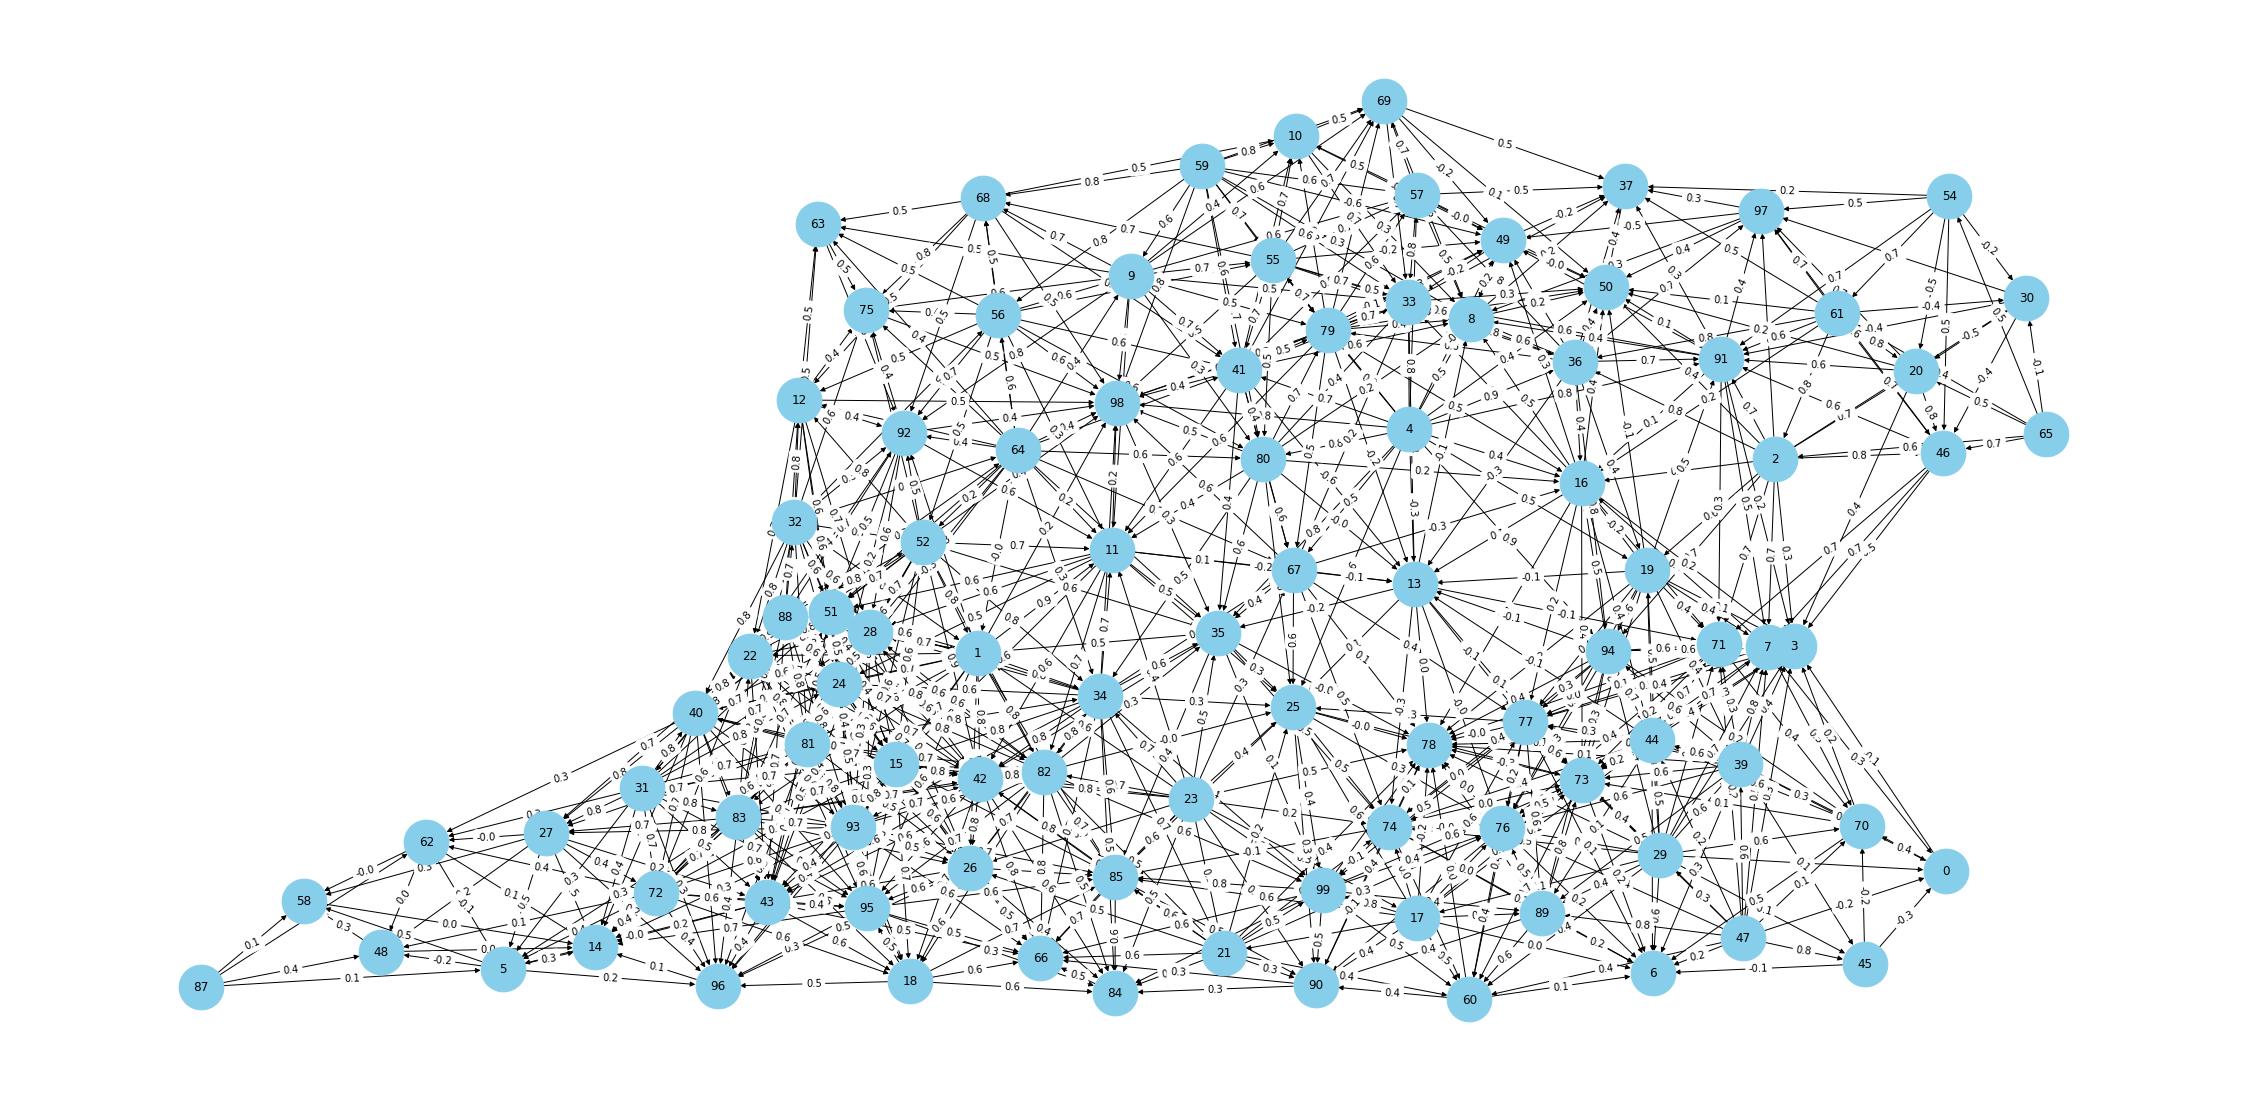

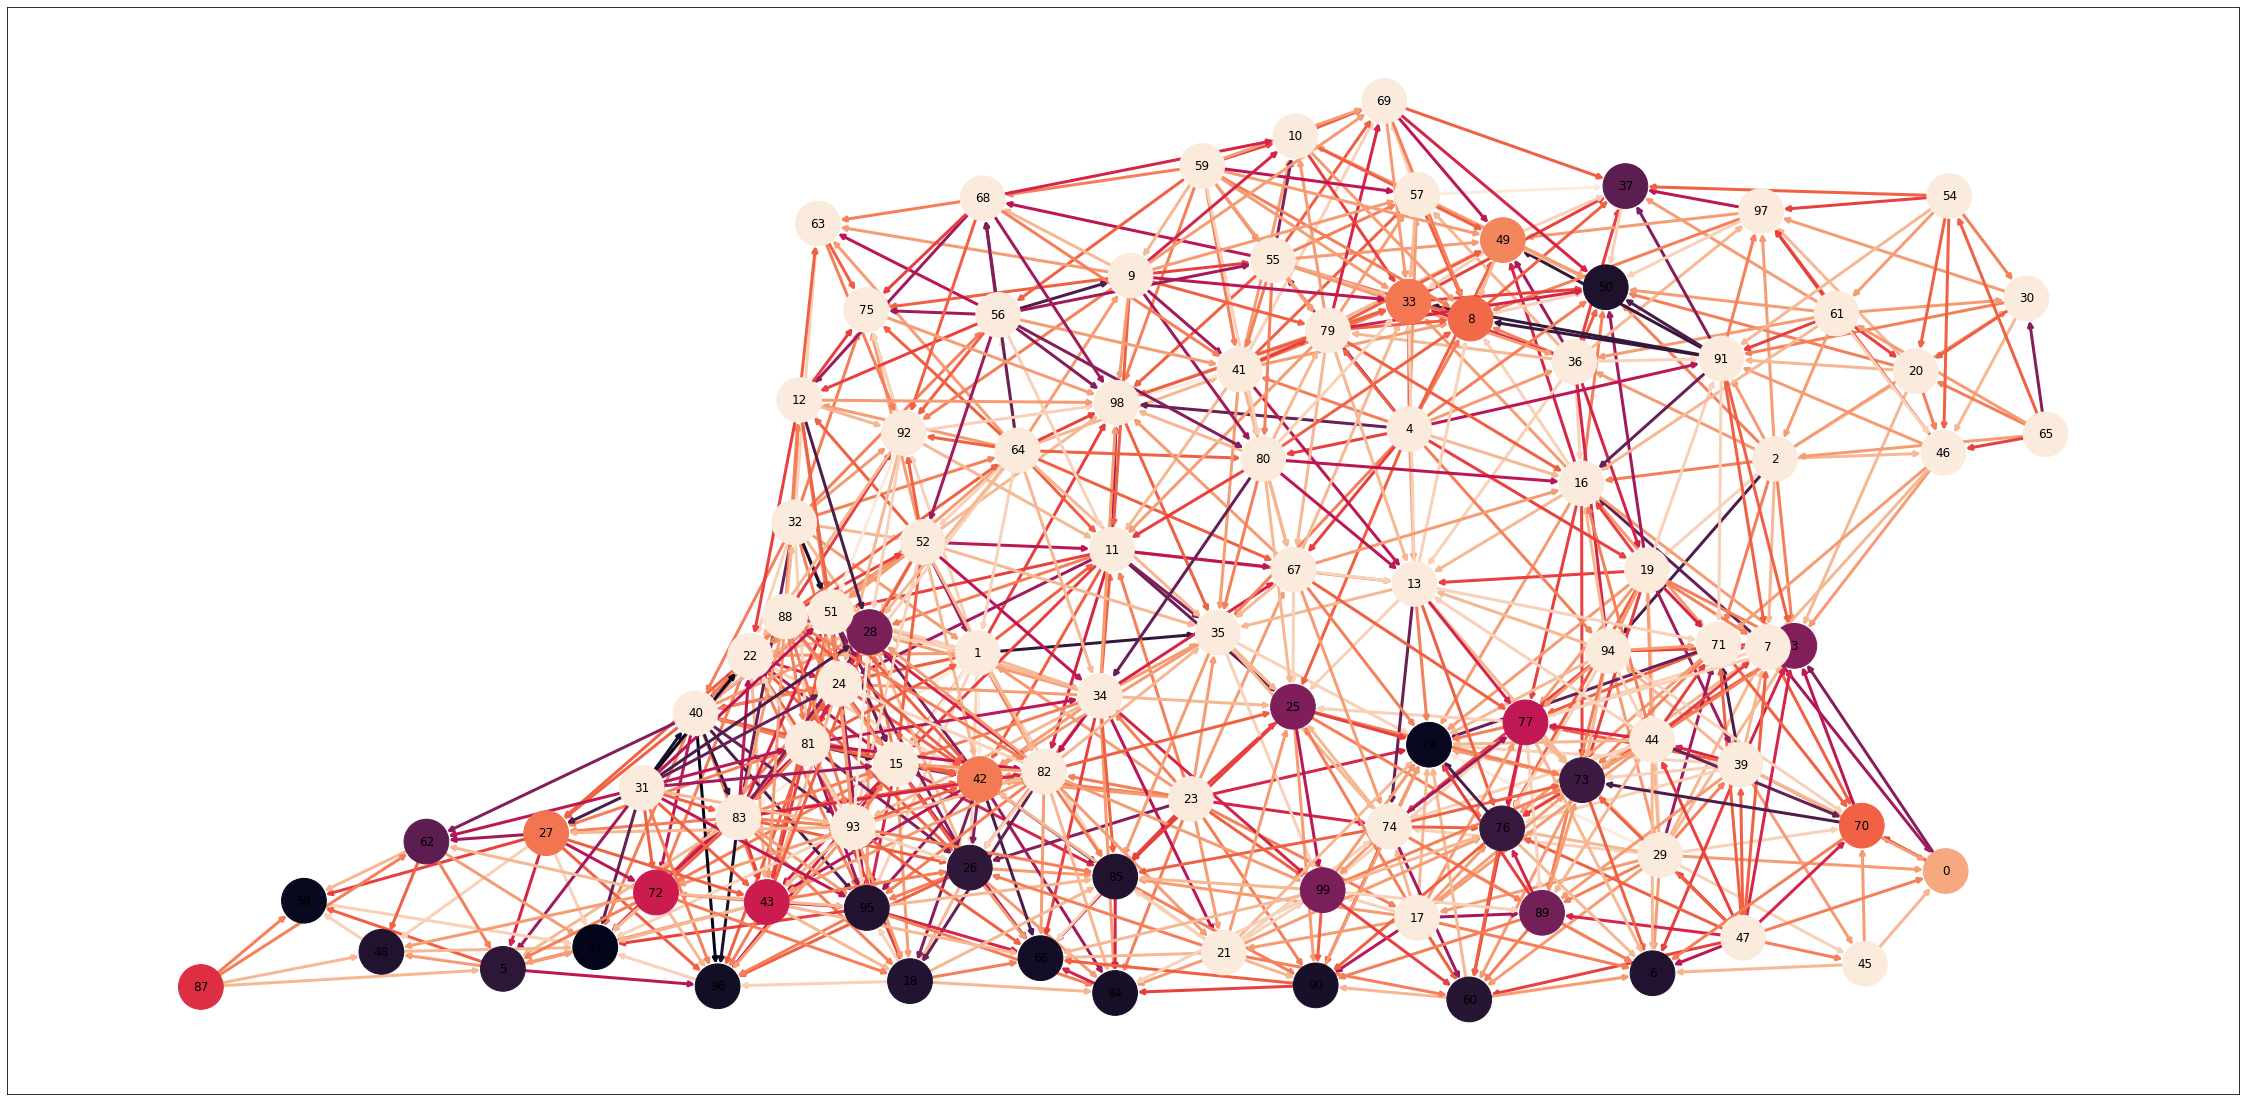

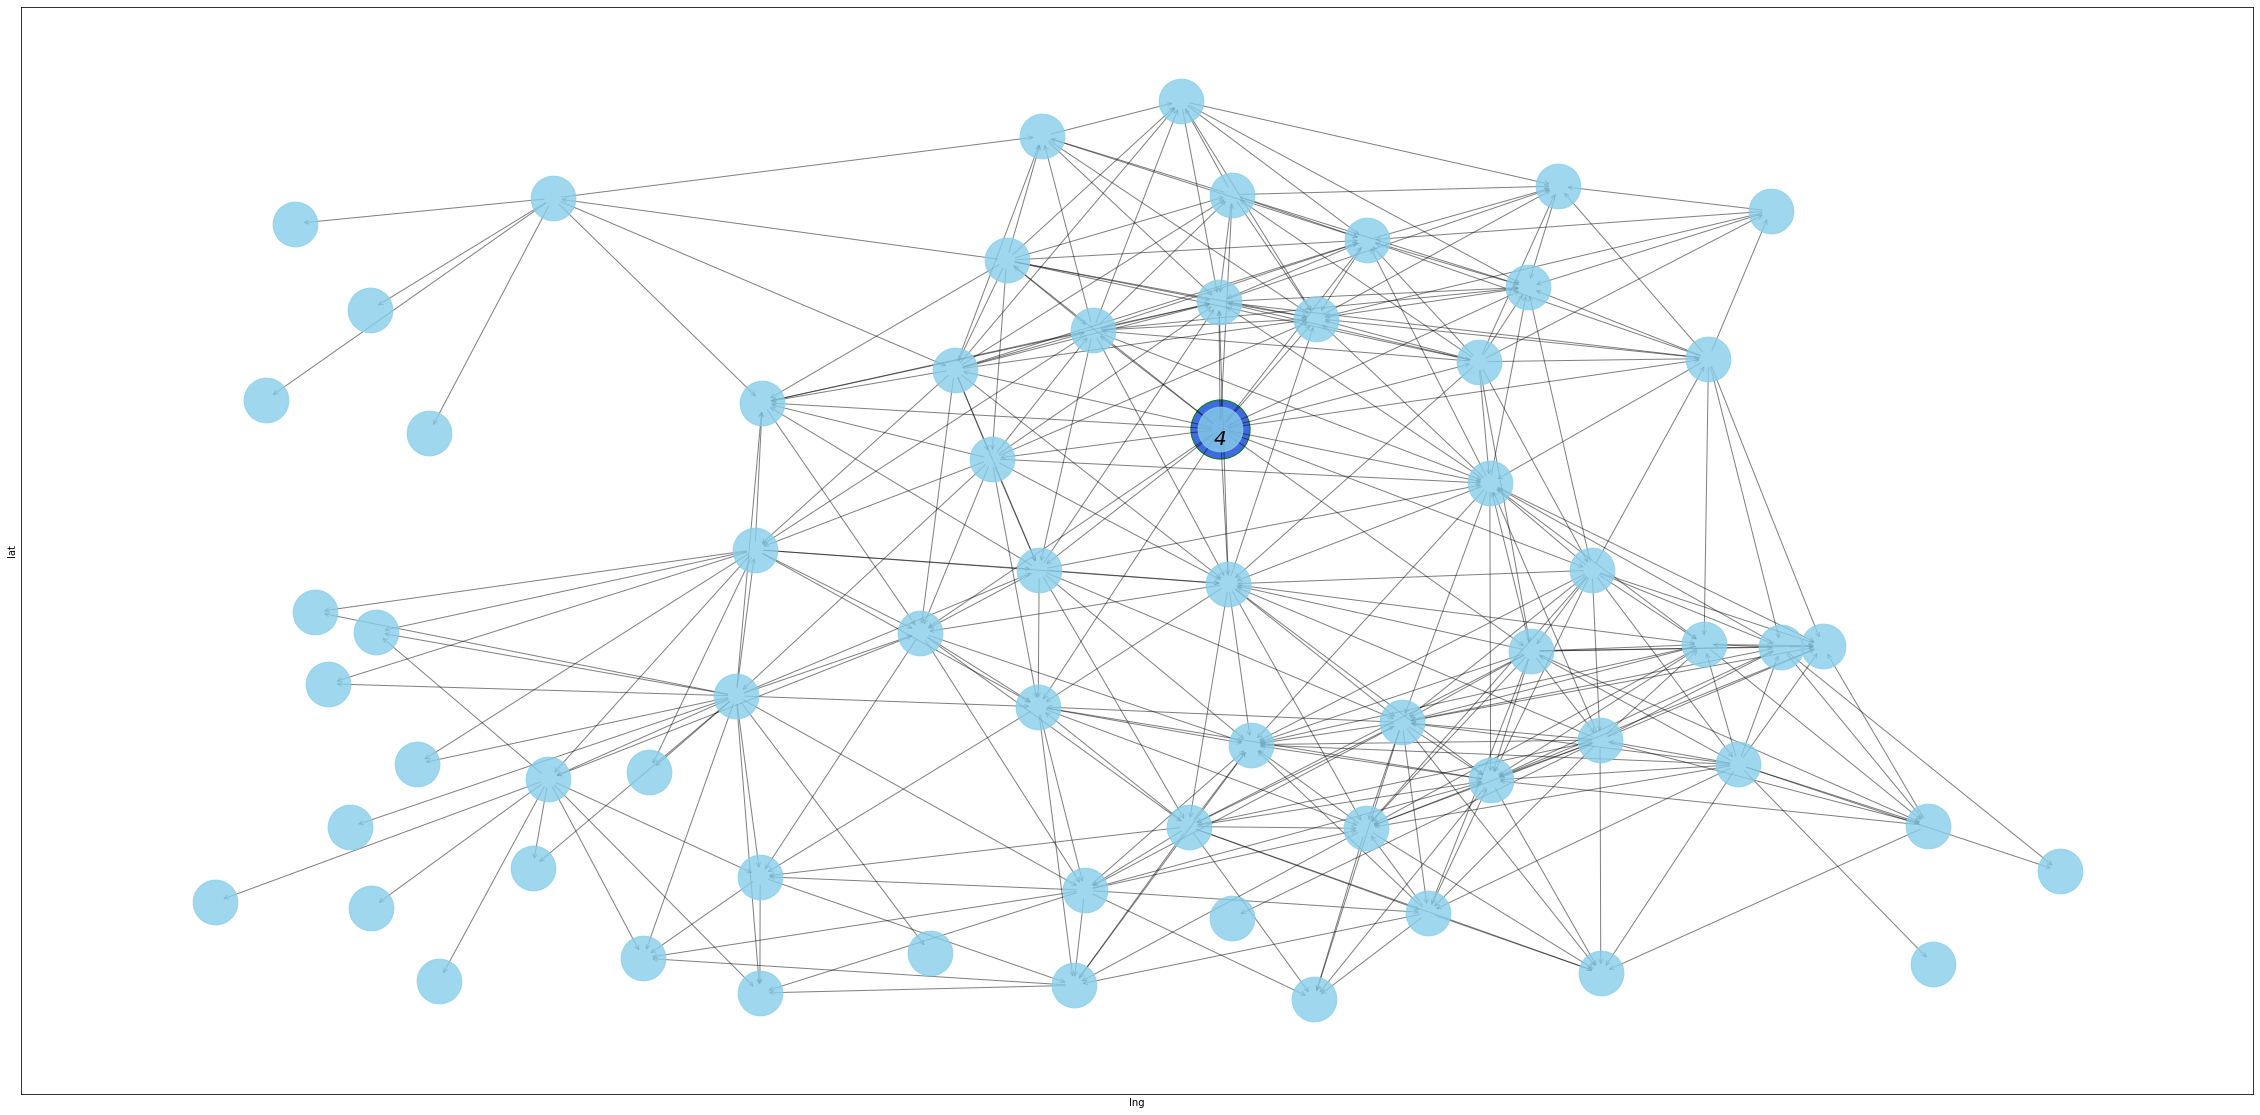

In [ ]:
if __name__ == '__main__':
    data = xlrd.open_workbook('kmeans.xls')
    drug2num, num2drug, dataslice, center = init(data)
    make_distance_xls(center)
    #cal_distance(center)
    trainingMatrix = np.zeros((100,69,7),dtype = np.int)
    #print(len(num2drug))

    # 得到的trainingMatrix是(100, 69, 7)的矩阵，反映了7年间每个区域各种毒品的数量
    for year in range(7):
        tmp = sparseMatrix(dataslice[year], drug2num, num2drug)
        for i in range(100):
            for j in range(len(num2drug)):
                trainingMatrix[i][j][year] += tmp[i][j]

    held_outMatrix = sparseMatrix(dataslice[7], drug2num, num2drug)

    #print(trainingMatrix)
    make_simi_xls(trainingMatrix,center,300000)
    #print(similarity(2, trainingMatrix, center, 300000))
    adjMatrix('Heroin', 2014, 200000)
    # #get_all_origin(2010, 200000)


最后的结果是81，论文里给的是32，应该是合理的，两个位置距离很近。

In [ ]:
data = pd.read_excel("MCM_NFLIS_Data.xlsx", sheet_name = 'Data')
data_2017 = data.groupby('YYYY').get_group(2017)
data_2017 = data_2017.groupby('FIPS_Combined').agg({'TotalDrugReportsCounty':'mean'})
data_2017

,TotalDrugReportsCounty
FIPS_Combined,
21001,136.0
21003,152.0
21005,43.0
21007,25.0
21009,359.0
...,...
54099,63.0
54101,46.0
54103,12.0


In [ ]:
px.colors.sequential

<module '_plotly_utils.colors.sequential' from '/usr/local/lib/python3.8/dist-packages/_plotly_utils/colors/sequential.py'>

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
import plotly.express as px

# 来看2017年的
def set_cat(row):
    if row['drugnum'] >= 0 and row['drugnum'] <= 100:
        return '0 - 100'
    if row['drugnum'] >= 101 and row['drugnum'] <= 200:
        return '101 - 200'
    if row['drugnum'] >= 201 and row['drugnum'] <= 400:
        return '201 - 400'
    if row['drugnum'] >= 401 and row['drugnum'] <= 800:
        return '401 - 800'
    if row['drugnum'] >= 801:
        return '801 - more'


data_zone = pd.DataFrame({'fips':data_2017.index.values, 'drugnum':data_2017['TotalDrugReportsCounty'].values} )
data_zone = data_zone.assign(category=data_zone.apply(set_cat, axis=1))

In [ ]:
fig = px.choropleth_mapbox(data_zone, geojson=counties, locations='fips', color="category",color_discrete_map={
                        '0 - 100' : '#b5de2b',
                        '101 - 200' : '#35b779',
                        '201 - 400' : '#26828e',
                        '401 - 800' : '#3e4989',
                        '801 - more' : '#440154'},

                                           
                    category_orders={
                      'category' :[ '0 - 100' ,
                              '101 - 200' ,
                              '201 - 400' ,
                              '401 - 800' ,
                              '801 - more' ,

                              
                      ]
                    },

                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                          labels={'category' : 'drugnum per area'},
                           title='<b>drugnum cases in USA')

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
configure_plotly_browser_state()

init_notebook_mode(connected=False)
fig.show()

算力还是不够哇，这种图还是要拿自己电脑跑，notebook跑还是很大局限性）悲

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
import plotly.express as px

# 来看2017年的
def set_cat(row):
    if row['drugnum'] >= 0 and row['drugnum'] <= 200:
        return '0 - 200'
    if row['drugnum'] >= 201 and row['drugnum'] <= 400:
        return '201 - 400'
    if row['drugnum'] >= 401 and row['drugnum'] <= 800:
        return '401 - 800'
    if row['drugnum'] >= 801 and row['drugnum'] <= 1500:
        return '801 - 1500'
    if row['drugnum'] >= 1501 and row['drugnum'] <= 2500:
        return '1501 - 2500'
    if row['drugnum'] >= 2501 and row['drugnum'] <= 4000:
        return '2501 - 4000'
    if row['drugnum'] >= 4001 and row['drugnum'] <= 6000:
        return  '4001 - 6000'
    if row['drugnum'] >= 6001 and row['drugnum'] <= 8000:
        return '6001 - 8000'
    if row['drugnum'] >= 8001 and row['drugnum'] <= 10000:
        return '8001 - 10000'
    if row['drugnum'] > 10000:
        return '10001 - more'


data_zone = pd.DataFrame({'fips':data_2017.index.values, 'drugnum':data_2017['TotalDrugReportsCounty'].values} )
data_zone = data_zone.assign(category=data_zone.apply(set_cat, axis=1))




In [ ]:
fig = px.choropleth_mapbox(data_zone, geojson=counties, locations='fips', color="category",color_discrete_map={
                        '0 - 200' : '#f0f921',
                        '201 - 400' : '#fdca26',
                        '401 - 800' : '#ffbaba',
                        '801 - 1500' : '#fb9f3a',
                        '1501 - 2500' : '#ed7953',
                        '2501 - 4000' : '#d8576b',
                        '4001 - 6000' : '#bd3786',
                        '6001 - 8000' : '#7201a8',
                        '8001 - 10000' : '#46039f',
                        '10001 - more' : '#0d0887'},
                    category_orders={
                      'category' : ['0 - 200' ,
                              '201 - 400' ,
                              '401 - 800' ,
                              '801 - 1500' ,
                              '1501 - 2500' ,
                              '2501 - 4000' ,
                              '4001 - 6000' ,
                              '6001 - 8000' ,
                              '8001 - 10000' ,
                              '10001 - more'
                      ]
                    },

                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                          labels={'category' : 'drugnum per area'},
                           title='<b>drugnum cases in USA')

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
configure_plotly_browser_state()

init_notebook_mode(connected=False)
fig.show()


### Data prediction

In [ ]:
import xlrd
import pandas as pd
import numpy as np
from math import *
import xlwt
import operator
import copy
from functools import reduce
from sklearn import svm
from sklearn.decomposition import PCA

def init_feature(feature):
    sheet = feature.sheet_by_name(u'extract_feature')
    factor = [[],[],[]]
    for row in range(1, sheet.nrows):
        entry = sheet.row_values(row)
        if entry[1] == 2010:
            factor[0].append(entry[3:])
        if entry[1] == 2011:
            factor[1].append(entry[3:])
        if entry[1] == 2012:
            factor[2].append(entry[3:])
    return factor



In [ ]:
'''
find the similarity between any zones
alpha is the distance coefficient
we only care about pairs whose distance
is within alpha
'''
def similarity(zone, data, center, alpha):
    adjacentZones = []
    for i in range(100):
        if i != zone and haversine(center[i], center[zone]) < alpha:
            Sum = np.sum(np.sum(np.array(data[i])))+np.sum(np.sum(np.array(data[zone])))
            corr = 0
            for j in range(69):
                tendency_i = data[i][j]
                tendency_zone = data[zone][j]
                sum_i = np.sum(np.array(tendency_i))
                sum_zone = np.sum(np.array(tendency_zone))
                if sum_zone == 0 or sum_i == 0:
                    continue
                por = sum_i + sum_zone
                coef = np.corrcoef(tendency_i, tendency_zone)[0,1]
                if isnan(coef) or coef == 0:
                    pass
                else:
                    corr += coef*1.0*por/Sum
            adjacentZones.append([i, corr])
    if len(adjacentZones) > 10:
        adjacentZones.sort(key=lambda x: x[1])
        return list(map(lambda x: x[0], adjacentZones[-10:]))
    else:
        return list(map(lambda x: x[0], adjacentZones))

def normalization(array):
    Sum = np.sum(np.array(array))
    return list(map(lambda x: x*1.0/Sum, array))

In [ ]:
'''
the purpose is to predict the drug spread tendency in following years
Note:
(1) for each zone and its every drug, if drug report is too smaller, we can’t
its tendency, we use the tendency from its similar zones to predict it
(2) if the specific drug in current zone has enough samples, then we combine
its tendency with that of its similar zones to predict
'''
def find_SVR_coef(data, center, held_outMatrix):
    features = {}
    axis = [[0],[1],[2],[3],[4],[5],[6]]
    for i in range(100):
        simi_zone = similarity(i, data, center, 200000)
        n = len(simi_zone)
        for j in range(69):
            # find each sample's tendency model
            feature = []
            clf = svm.SVR(gamma='auto', degree = 3 , kernel='poly')
            clf.fit(axis, data[i][j])
            feature.append(clf)
            for k in range(n):
                clf = svm.SVR(gamma='auto', degree = 3 , kernel='poly')
                clf.fit(axis, data[simi_zone[k]][j])
                feature.append(clf)
            # use held_out data to find the weight of each model
            weight = []
            for f in feature:
                pre = f.predict([[7]])
                real = held_outMatrix[i][j]
                weight.append(1.0/(0.01+np.square(pre-real)))
            weight = normalization(weight)
            features[(i, j)] = [feature, weight]
    return features


def find_SVR_coef_Mul(data, center, held_outMatrix, factor):
    features = {}
    for i in range(100):
        axis = []
        simi_zone = similarity(i, data, center, 200000)
        n = len(simi_zone)
        feature = []
        for j in range(3):
            # pca=PCA(n_components=1)
            # newaxis=pca.fit_transform(factor[j][i])
            # axis.append([newaxis])
            axis.append(factor[j][i])
        clf = svm.SVR(gamma='auto', kernel='poly')
        # print(axis)
        # print([np.sum(list(map(lambda x: x[0],data[i]))), np.sum(list(map(lambda x: x[1],data[i])))])
        clf.fit(axis, [np.sum(list(map(lambda x: x[0],data[i]))),
        np.sum(list(map(lambda x: x[1],data[i]))), np.sum(list(map(lambda x: x[2],data[i])))])
        feature.append(clf)
        for k in range(n):
            axis=[]
            for t in range(3):
                axis.append(factor[t][simi_zone[k]])
            clf = svm.SVR(gamma='auto', kernel='poly')
            clf.fit(axis, [np.sum(list(map(lambda x: x[0],data[simi_zone[k]]))),
            np.sum(list(map(lambda x: x[1],data[simi_zone[k]]))), np.sum(list(map(lambda x: x[2],data[i])))])
            feature.append(clf)
        weight = []
        for f in feature:
            pre = f.predict([factor[2][i]])
            real = held_outMatrix[i]
            weight.append(1.0/(1+abs(pre-real)))
        weight = normalization(weight)
        features[i] = [feature, weight]
    return features

def predict(features, year):
    t = year - 2010
    predict = np.zeros([100, 69])
    for i in range(100):
        for j in range(69):
            f, w = features[(i, j)]
            pre = round(np.sum(list(map(lambda x, y: x.predict([[t]])*y, f, w))),0)
            if pre > 0:
                predict[i][j] = pre
            else:
                predict[i][j] = 0
    return predict


def predict_Mul(features, new_factor):
    predict = np.zeros([100, 1])
    for i in range(100):
        new_f = new_factor[i]
        f, w = features[i]
        pre = round(np.sum(list(map(lambda x, y: x.predict([new_f])*y, f, w))),0)
        if pre > 0:
            predict[i] = pre
        else:
            predict[i] = 0
    return predict

In [ ]:
if __name__ == '__main__':
    data = xlrd.open_workbook('kmeans.xls')
    drug2num, num2drug, dataslice, center = init(data)
    trainingMatrix = np.zeros((100,69,7), dtype = np.int)
    for year in range(7):
        tmp = sparseMatrix(dataslice[year], drug2num, num2drug)
        for i in range(100):
            for j in range(len(num2drug)):
                trainingMatrix[i][j][year] += tmp[i][j]
    held_outMatrix = sparseMatrix(dataslice[7], drug2num, num2drug)
    # extract_feature = xlrd.open_workbook('extract_feature.xls')
    # factor = init_feature(extract_feature)
    # print('------------real--------------')
    # real = np.zeros([100,1])
    # for i in range(len(dataslice[2])):
    #     entry = dataslice[2][i]
    #     real[int(entry[1])] += entry[3]
    # print(real)
    # print([list(map(lambda x: x[2], dataslice[2][i])) for i in range(100)])
    # print('------------pre---------------')
    # train = find_SVR_coef_Mul(trainingMatrix, center, real, factor)
    # pre = predict_Mul(train, factor[2])
    # print(pre)
    # factor_new = [[12., 5, 27]]*100
    # pre_new = predict_Mul(train, factor_new)
    # for i in range(100):
    # print('real: {0} --- pre: {1} --- new: {2} --- zone: {3}'.format(real[i], pre[i], pre_new[i], i))
    # print('real: {0} --- pre: {1} --- new: {2} --- zone: {3}'.format(real[88], pre[88], pre_new[88], 88))
    features = find_SVR_coef(trainingMatrix, center, held_outMatrix)
    print(features)
    print('--------------2017predict---------------------')
    pred2017 = predict(features, 2017)
    print(pred2017)
    print(held_outMatrix[0][1])
    print(trainingMatrix[0][1])
    sim = similarity(0,trainingMatrix,center,300000)
    print(sim)
    for s in sim:
    print(trainingMatrix[s][1],'---------------')
    print('-----------------2017real----------------------')
    real2017 = sparseMatrix(dataslice[7], drug2num, num2drug)
    print(real2017)
    diff = np.array(pred2017) - np.array(real2017)
    d = np.sum(list(map(lambda x: abs(x), diff)))
    print(d)
    # print('-----------------2018predict---------------------')
    # rel2018 = predict(features, 2018)
    # print(rel2018)
    # print('-----------------2019predict---------------------')
    # rel2019 = predict(features, 2019)
    # print(rel2019)
    # excel = xlwt.Workbook()
    # sheet = excel.add_sheet("Predicted Date based on Zone")
    # sheet.write(0, 0, "YYYY")
    # sheet.write(0, 1, "Zone")
    # sheet.write(0, 2, "substanceName")
    # sheet.write(0, 3, "DrugReportZone")
    # row = 0
    # for zone in range(len(rel2018)):
    # for drug in range(69):
    # row += 1
    # substanceName = num2drug[drug]
    # sheet.write(row, 0, 2018)
    # sheet.write(row, 1, zone)
    # sheet.write(row, 2, substanceName)
    # sheet.write(row, 3, rel2018[zone][drug])
    # for zone in range(len(rel2019)):
    # for drug in range(69):
    # row += 1
    # substanceName = num2drug[drug]
    # sheet.write(row, 0, 2019)
    # sheet.write(row, 1, zone)
    # sheet.write(row, 2, substanceName)
    # sheet.write(row, 3, rel2018[zone][drug])
    # excel.save("/Users/lsd/Desktop/code/Model/predict.xls")

关联规则参考资料：[link](https://bainingchao.github.io/2018/09/27/%E4%B8%80%E6%AD%A5%E6%AD%A5%E6%95%99%E4%BD%A0%E8%BD%BB%E6%9D%BE%E5%AD%A6%E5%85%B3%E8%81%94%E8%A7%84%E5%88%99Apriori%E7%AE%97%E6%B3%95/)